In [1]:
pip install pandas numpy matplotlib seaborn scikit-learn nltk torch tqdm


In [2]:
import pandas as pd

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train



,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [3]:
print(train['target'].value_counts())

target
0    4342
1    3271
Name: count, dtype: int64


array([[<Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'target'}>]], dtype=object)

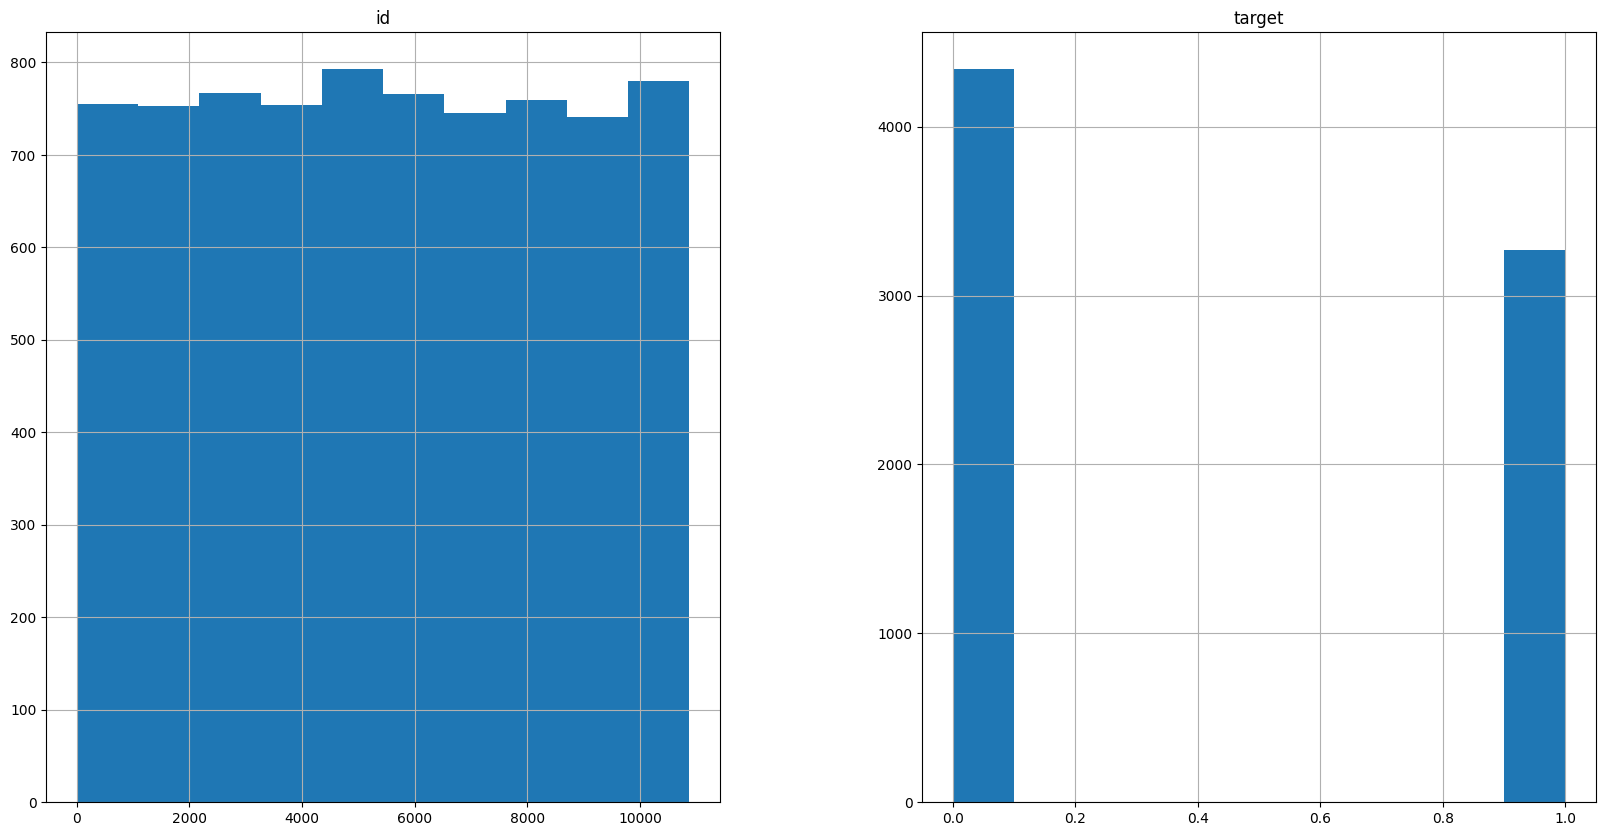

In [4]:
train.hist(figsize=(20,10))

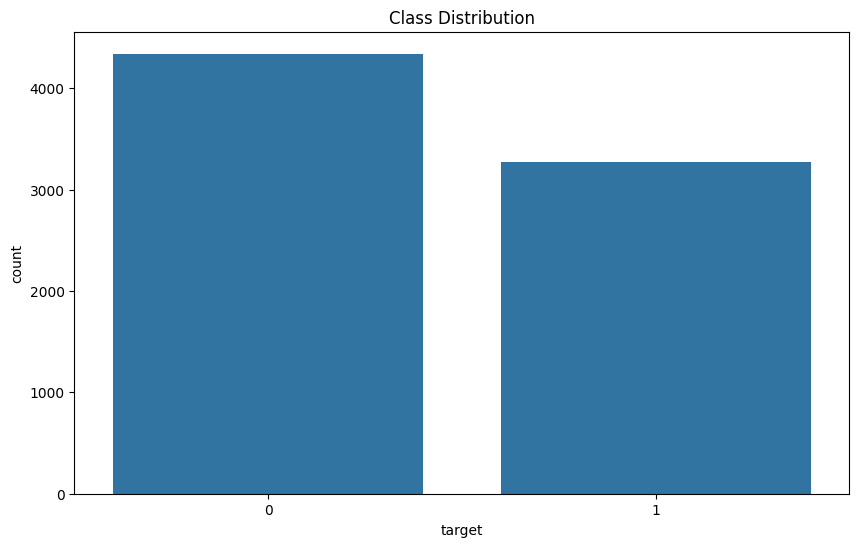

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.countplot(x=train['target'])
plt.title("Class Distribution")
plt.show()


In [6]:
for _ in range(5):
    print(train.sample(1)['text'].values[0])
# to print samples with noise

County 911 Overload Prompts Use of Emergency Plan During July 4 Celebrations http://t.co/HXTUPrA5bc http://t.co/DqxKJibbKy
#DebateQuestionsWeWantToHear Why does #Saudi arabia and #Israel get away with mass murder?
#Wahhabism #Zionism
USGS reports a M1.94 #earthquake 5km S of Volcano Hawaii on 8/6/15 @ 1:04:01 UTC http://t.co/Njd28pg9Xv #quake
@Rubi_ How many stacks of burning did it apply?
Tips to prevent basement leaks - Create control joints to eliminate random cracking. #homeimprovement #Flooding http://t.co/Kx8cU4s8T1


In [7]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:

trusted_sources = {"cnn", "bbc", "reuters", "ap"}
NEGATIONS = {"no", "not", "never"}


def replace_mentions(text):
    def helper(match):
        user = match.group()[1:].lower()
        return "<NEWS>" if user in trusted_sources else "<USER>"
    return re.sub(r"@\w+", helper, text)

def clean_text(text):
    text = text.lower()
    text = replace_mentions(text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^\w\s'<]", "", text)

    tokens = text.split()
    tokens = [
        t for t in tokens
        if (t not in stop_words) or (t in NEGATIONS)
    ]
    return " ".join(tokens)


train['clean'] = train['text'].apply(clean_text)
test['clean'] = test['text'].apply(clean_text)


In [9]:
train[['text', 'clean']].head(10)


,text,clean
0,Our Deeds are the Reason of this #earthquake M...,deeds reason earthquake may allah forgive us
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,residents asked 'shelter place' notified offic...
3,"13,000 people receive #wildfires evacuation or...",13000 people receive wildfires evacuation orde...
4,Just got sent this photo from Ruby #Alaska as ...,got sent photo ruby alaska smoke wildfires pou...
5,#RockyFire Update => California Hwy. 20 closed...,rockyfire update california hwy 20 closed dire...
6,#flood #disaster Heavy rain causes flash flood...,flood disaster heavy rain causes flash floodin...
7,I'm on top of the hill and I can see a fire in...,top hill see fire woods
8,There's an emergency evacuation happening now ...,there's emergency evacuation happening buildin...
9,I'm afraid that the tornado is coming to our a...,afraid tornado coming area


In [10]:
train['clean']


,clean
0,deeds reason earthquake may allah forgive us
1,forest fire near la ronge sask canada
2,residents asked 'shelter place' notified offic...
3,13000 people receive wildfires evacuation orde...
4,got sent photo ruby alaska smoke wildfires pou...
...,...
7608,two giant cranes holding bridge collapse nearb...
7609,<USER <USER control wild fires california even...
7610,m194 0104 utc5km volcano hawaii
7611,police investigating ebike collided car little...


In [11]:
test['clean']

,clean
0,happened terrible car crash
1,heard earthquake different cities stay safe ev...
2,forest fire spot pond geese fleeing across str...
3,apocalypse lighting spokane wildfires
4,typhoon soudelor kills 28 china taiwan
...,...
3258,earthquake safety los angeles ûò safety fasten...
3259,storm ri worse last hurricane cityamp3others h...
3260,green line derailment chicago
3261,meg issues hazardous weather outlook hwo


In [33]:
DISASTER_WORDS = {
    "fire", "flood", "earthquake", "evacuation",
    "explosion", "hurricane", "tornado", "wildfire"
}

def has_disaster_word(text):
    return int(any(word in text for word in DISASTER_WORDS))

train["has_disaster_word"] = train["clean"].apply(has_disaster_word)
test["has_disaster_word"] = test["clean"].apply(has_disaster_word)


In [34]:
from sklearn.model_selection import train_test_split

X_train_text, X_val_text, y_train, y_val = train_test_split(
    train["clean"],
    train["target"],
    test_size=0.2,
    random_state=42,
    stratify=train["target"]
)

X_train_feat = train.loc[X_train_text.index, "has_disaster_word"].values
X_val_feat = train.loc[X_val_text.index, "has_disaster_word"].values


In [35]:
from collections import Counter

def build_vocab(texts, max_size=10000):
    counter = Counter()
    for text in texts:
        counter.update(text.split())

    vocab = {"<PAD>": 0, "<UNK>": 1}
    for word, _ in counter.most_common(max_size - 2):
        vocab[word] = len(vocab)

    return vocab

vocab = build_vocab(X_train_text)


In [51]:
MAX_LEN = 30

def encode_text(text, vocab):
    tokens = text.split()
    ids = [vocab.get(tok, vocab["<UNK>"]) for tok in tokens]
    ids = ids[:MAX_LEN]
    return ids + [vocab["<PAD>"]] * (MAX_LEN - len(ids))

X_train_enc = [encode_text(t, vocab) for t in X_train_text]
X_val_enc = [encode_text(t, vocab) for t in X_val_text]


In [52]:
import torch
from torch.utils.data import Dataset

class TweetDataset(Dataset):
    def __init__(self, X, extra_feat, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.extra = torch.tensor(extra_feat, dtype=torch.float)
        self.y = torch.tensor(y.values, dtype=torch.float)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.extra[idx], self.y[idx]




In [53]:
from torch.utils.data import DataLoader

train_ds = TweetDataset(X_train_enc, X_train_feat, y_train)
val_ds = TweetDataset(X_val_enc, X_val_feat, y_val)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)



In [54]:
import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=64):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)

        # +1 because we concatenate has_disaster_word
        self.fc = nn.Linear(hidden_dim + 1, 1)

    def forward(self, x, extra):
        x = self.embedding(x)
        _, (h, _) = self.lstm(x)

        # Combine LSTM output with auxiliary feature
        combined = torch.cat([h[-1], extra.unsqueeze(1)], dim=1)

        return self.fc(combined).squeeze()


In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LSTMClassifier(len(vocab)).to(device)

# Penalize missing disasters more heavily
pos_weight = torch.tensor([2.0]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



In [70]:
EPOCHS = 5

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for X_batch, feat_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        feat_batch = feat_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        logits = model(X_batch, feat_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} | Loss: {total_loss:.4f}")


Epoch 1 | Loss: 156.9357
Epoch 2 | Loss: 150.7666
Epoch 3 | Loss: 147.7614
Epoch 4 | Loss: 152.9469
Epoch 5 | Loss: 139.2935


In [71]:
print("Probability stats:")
print("Min:", probs.min().item())
print("Max:", probs.max().item())
print("Mean:", probs.mean().item())


Probability stats:
Min: 0.3652130663394928
Max: 0.8640533089637756
Mean: 0.5154238939285278


In [84]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
THRESHOLD = 0.41  # was decided after multiple trial submissions on kaggle--0.71805

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for X_batch, feat_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)
        feat_batch = feat_batch.to(device)

        logits = model(X_batch, feat_batch)
        probs = torch.sigmoid(logits)

        preds = (probs > THRESHOLD).int().cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y_batch.numpy())

print("F1 Score:", f1_score(all_labels, all_preds))
print(classification_report(all_labels, all_preds))


F1 Score: 0.6835443037974683
              precision    recall  f1-score   support

         0.0       0.77      0.74      0.75       869
         1.0       0.67      0.70      0.68       654

    accuracy                           0.72      1523
   macro avg       0.72      0.72      0.72      1523
weighted avg       0.72      0.72      0.72      1523



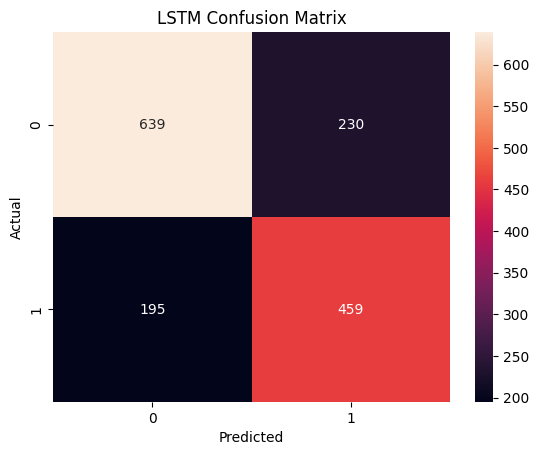

In [82]:
cm = confusion_matrix(all_labels, all_preds)

import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("LSTM Confusion Matrix")
plt.show()


In [83]:
# Step 1: Convert cleaned test text into numbers (same way as training)
test_encoded = []

for text in test["clean"]:
    encoded_text = encode_text(text, vocab)
    test_encoded.append(encoded_text)


# Step 2: Get the additional feature (presence of disaster-related words)
test_extra_feature = test["has_disaster_word"].values


# Step 3: Convert everything to PyTorch tensors
test_text_tensor = torch.tensor(test_encoded, dtype=torch.long).to(device)
test_feature_tensor = torch.tensor(test_extra_feature, dtype=torch.float).to(device)


# Step 4: Put the model in evaluation mode
model.eval()


# Step 5: Make predictions (no training, no gradients)
with torch.no_grad():
    raw_outputs = model(test_text_tensor, test_feature_tensor)
    probabilities = torch.sigmoid(raw_outputs)


# Step 6: Convert probabilities to class labels using the chosen threshold
test_predictions = (probabilities > THRESHOLD).int().cpu().numpy()


# Step 7: Create submission file in required Kaggle format
submission = pd.DataFrame({
    "id": test["id"],
    "target": test_predictions
})


# Step 8: Save predictions to CSV
submission.to_csv("submission.csv", index=False)

print("submission.csv file created successfully")


submission.csv file created successfully
